# Importing Libraries 

In [29]:
# 📘 Online Retail Analysis: Python + SQL (SQLite)

# 📦 Step 1: Import Libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# 🧾 Step 2: Load Dataset

In [30]:
df = pd.read_excel('online_retail.xlsx')

In [31]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 🧹 Step 3: Data Preprocessing

In [32]:
df.dropna(subset=['Customer ID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['Price']

In [33]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# 💾 Step 4: Create SQLite DB and Save Table

In [34]:
conn = sqlite3.connect('online_retail.db')
df.to_sql('transactions', conn, if_exists='replace', index=False)


417534

# 🔍 Step 5: Top Customers by Revenue

In [38]:
query = """
SELECT [Customer ID], SUM(TotalPrice) as Revenue
FROM transactions
GROUP BY [Customer ID]
ORDER BY Revenue DESC
"""
top_customers = pd.read_sql(query, conn)
print("Top Customers by Revenue:")
print(top_customers)

Top Customers by Revenue:
      Customer ID    Revenue
0         18102.0  341776.73
1         14646.0  243853.05
2         14156.0  183180.55
3         14911.0  137675.91
4         13694.0  128172.42
...           ...        ...
4378      16981.0   -4620.86
4379      15760.0   -5795.87
4380      15849.0   -5876.34
4381      12918.0  -10953.50
4382      17399.0  -25111.09

[4383 rows x 2 columns]


# 📦 Step 6: Most Popular Products

In [12]:
query = """
SELECT Description, SUM(Quantity) as TotalQuantity
FROM transactions
GROUP BY Description
ORDER BY TotalQuantity DESC
LIMIT 10;
"""
top_products = pd.read_sql(query, conn)
print("\nTop 10 Products by Quantity Sold:")
print(top_products)


Top 10 Products by Quantity Sold:
                          Description  TotalQuantity
0  WHITE HANGING HEART T-LIGHT HOLDER          55861
1   WORLD WAR 2 GLIDERS ASSTD DESIGNS          54274
2                 BROCADE RING PURSE           47430
3    PACK OF 72 RETRO SPOT CAKE CASES          44507
4       ASSORTED COLOUR BIRD ORNAMENT          44120
5         60 TEATIME FAIRY CAKE CASES          35630
6  PACK OF 60 PINK PAISLEY CAKE CASES          30888
7             JUMBO BAG RED RETROSPOT          29498
8  BLACK AND WHITE PAISLEY FLOWER MUG          25679
9                SMALL POPCORN HOLDER          25394


# 🌍 Step 7: Sales by Country

In [13]:
query = """
SELECT Country, SUM(TotalPrice) as Revenue
FROM transactions
GROUP BY Country
ORDER BY Revenue DESC
LIMIT 10;
"""
sales_by_country = pd.read_sql(query, conn)
print("\nTop 10 Countries by Sales:")
print(sales_by_country)


Top 10 Countries by Sales:
          Country      Revenue
0  United Kingdom  7038549.633
1            EIRE   328216.410
2     Netherlands   263863.410
3         Germany   196290.351
4          France   129773.830
5          Sweden    50859.510
6         Denmark    46972.950
7     Switzerland    43343.410
8           Spain    37084.900
9       Australia    30051.800


# 📈 Step 8: Monthly Sales Trend

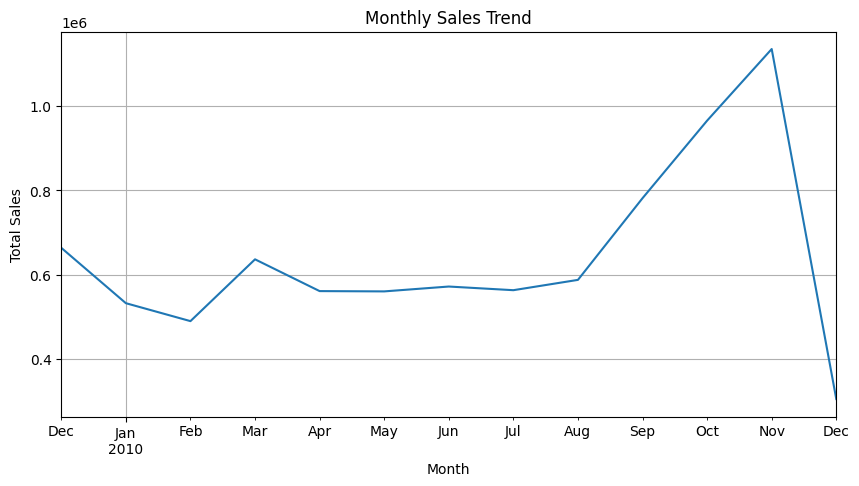

In [14]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.plot(kind='line', title='Monthly Sales Trend', figsize=(10,5))
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# 🔁 Step 9: Top Returning Customers

In [16]:
query = """
SELECT [Customer ID], COUNT(DISTINCT Invoice) AS OrderCount
FROM transactions
GROUP BY [Customer ID]
ORDER BY OrderCount DESC
LIMIT 10;
"""
top_returning = pd.read_sql(query, conn)
print("\nTop Returning Customers:")
print(top_returning)


Top Returning Customers:
   Customer ID  OrderCount
0      14911.0         270
1      12748.0         159
2      17850.0         158
3      15311.0         158
4      14156.0         138
5      14606.0         135
6      13089.0         132
7      17841.0         126
8      14527.0         108
9      13694.0         105


# 🔍 Step 10: RFM Analysis

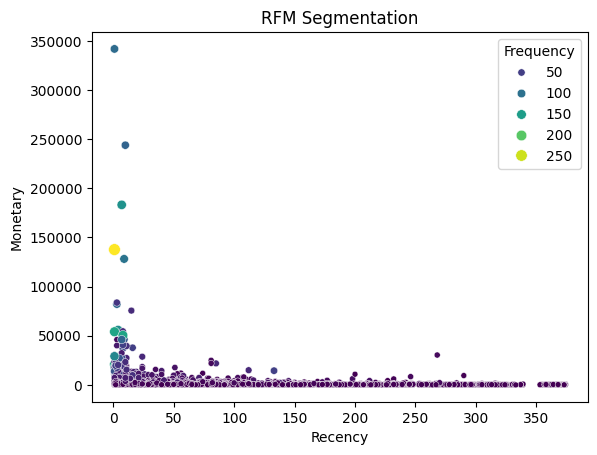

In [18]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]
sns.scatterplot(data=rfm, x='Recency', y='Monetary', size='Frequency', hue='Frequency', palette='viridis')
plt.title('RFM Segmentation')
plt.show()


# 🛒 Step 11: Basket Size Analysis

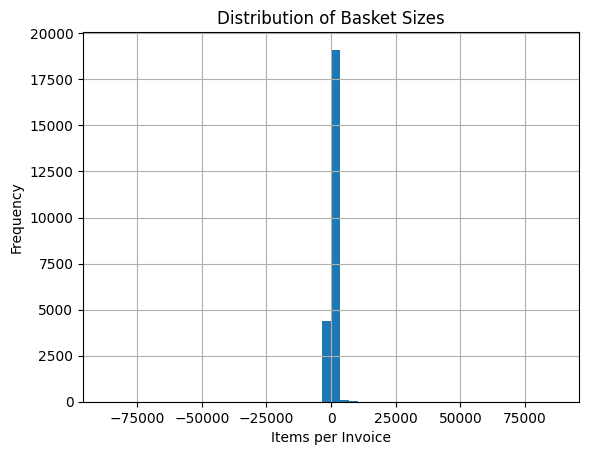

In [20]:
basket_size = df.groupby('Invoice')['Quantity'].sum()
plt.hist(basket_size, bins=50)
plt.title('Distribution of Basket Sizes')
plt.xlabel('Items per Invoice')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ⏰ Step 12: Time-of-Day Purchase Analysis

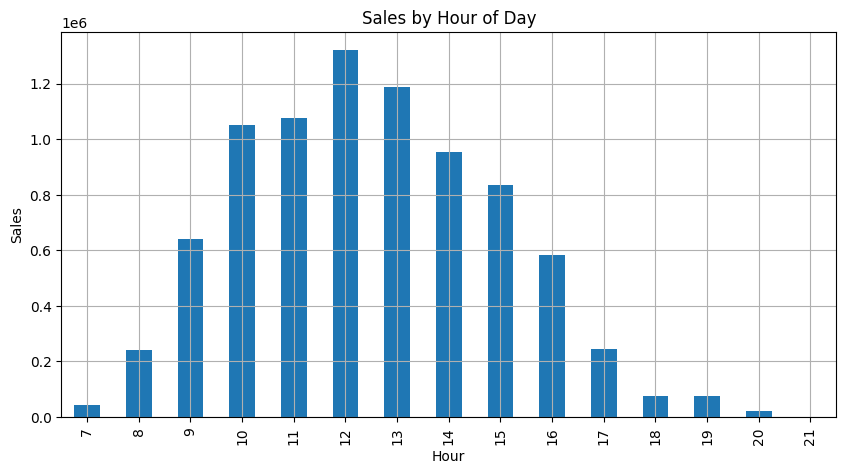

In [21]:
df['Hour'] = df['InvoiceDate'].dt.hour
sales_by_hour = df.groupby('Hour')['TotalPrice'].sum()
sales_by_hour.plot(kind='bar', title='Sales by Hour of Day', figsize=(10,5))
plt.xlabel('Hour')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# 🚫 Step 13: Cancellation Analysis

In [22]:
cancellations = df[df['Invoice'].astype(str).str.startswith('C')]
cancel_rate = len(cancellations) / len(df)
print(f"\nCancellation Rate: {cancel_rate:.2%}")



Cancellation Rate: 2.36%


# ✅ Close connection

In [23]:
conn.close()